In [33]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 1000)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from utils import createXYPlot
from utils import getVariables
from datetime import datetime

today = str(datetime.now().date())
print(today)
plots_folder = f"./plots/{today}/iss"
os.system(f"mkdir -p {plots_folder}")

2022-01-17


0

### Iss data

In [34]:
df_ti = pd.read_csv("./data/rapporti_ISS - TI.csv")
df_decessi = pd.read_csv("./data/rapporti_ISS - Decessi.csv")
df_ricoveri = pd.read_csv("./data/rapporti_ISS - Ricoveri.csv")
df_contagi = pd.read_csv("./data/rapporti_ISS - Contagi.csv")
df_pop = pd.read_csv("./data/rapporti_ISS - Popolazione.csv")

In [35]:
cols_to_select = [x for x in df_pop.columns if "frac" not in x and x != "cut"]
df_pop = df_pop[cols_to_select]
df_pop["data"] = pd.to_datetime(df_pop["data"]).dt.date
df_pop = df_pop.rename(columns={"data":"data_pop"})

In [36]:
df_dict = {
    "contagi": df_contagi,
    "ricoveri": df_ricoveri,
    "terapie_intensive": df_ti, 
    "decessi": df_decessi
}

In [37]:
for d in df_dict.items():
    d[1]["split"] = d[0]

In [38]:
df_iss = pd.concat(df_dict.values()).reset_index(drop=True)
df_iss["tot"] = df_iss["vax"] + df_iss["no_vax"]
df_iss["data"] = pd.to_datetime(df_iss["data"]).dt.date

In [39]:
age_values = df_iss["fascia_eta"].unique()
splits = df_iss["split"].unique()

In [40]:
from datetime import timedelta
df_iss["data_pop"] = df_iss["data"].apply(lambda x: x - timedelta(14))

In [41]:
df_iss = df_iss.merge(df_pop, on=["data_pop","fascia_eta"], how="left", suffixes=("","_pop"))

### Incidence

In [42]:
vnames = ["no_vax", "vax"]
for v in vnames:
    df_iss[f"{v}_100k"] = (1e5)*df_iss[v]/df_iss[f"{v}_pop"]
df_iss["eff"] = 100*(1 - df_iss[f"vax_100k"]/df_iss[f"no_vax_100k"])

,data,no_vax_100k,vax_100k
4,2021-11-07,483.953431,122.011740
9,2021-11-14,643.097858,164.990966
14,2021-11-21,816.080858,220.765450
19,2021-11-28,1019.798641,287.681595
24,2021-12-05,1278.436013,359.885271
29,2021-12-12,1601.383283,438.416948
34,2021-12-19,2000.625458,562.106418
39,2021-12-26,2480.132878,849.393879
44,2022-01-02,3774.805890,1809.843200
49,2022-01-09,6164.565193,3336.867423


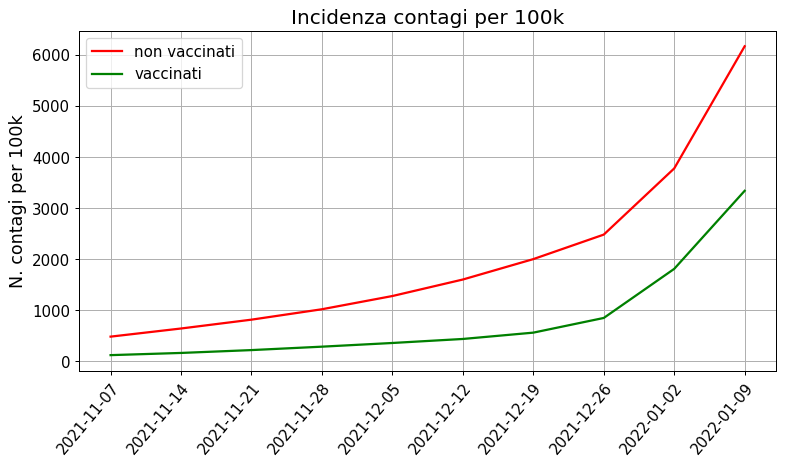

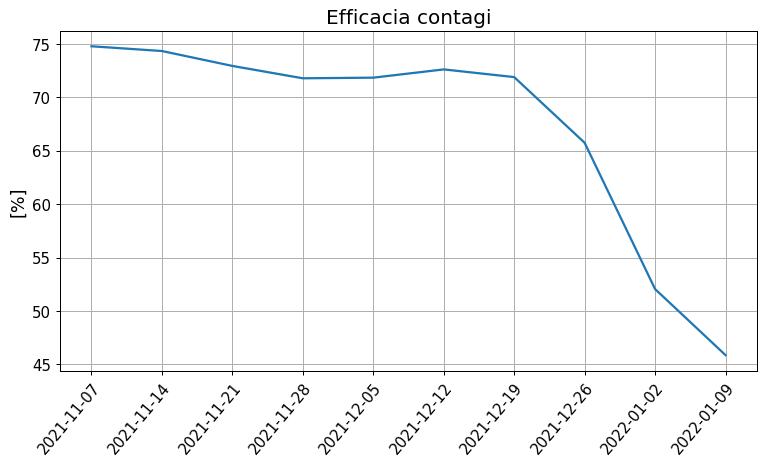

,data,no_vax_100k,vax_100k
54,2021-10-24,NaN,NaN
59,2021-10-31,NaN,NaN
64,2021-11-07,45.008560,8.477899
69,2021-11-14,47.478133,8.802234
74,2021-11-21,58.027847,10.554901
79,2021-11-28,68.619516,12.305456
84,2021-12-05,81.517096,14.341299
89,2021-12-12,98.576526,16.194579
94,2021-12-19,117.724842,18.035990
99,2021-12-26,139.078580,21.392538


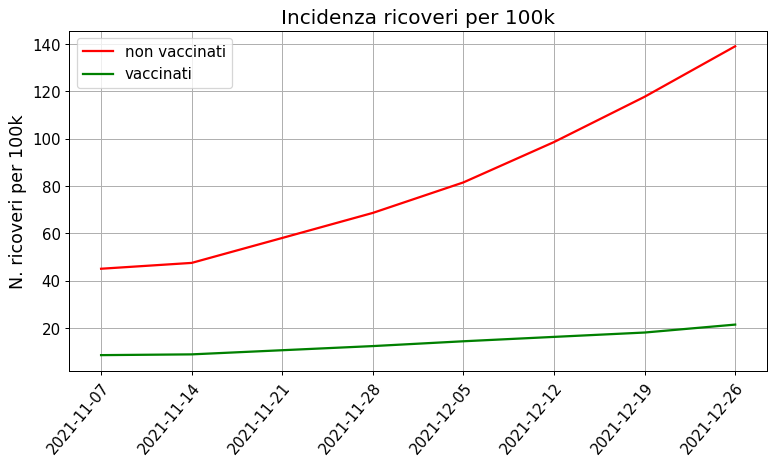

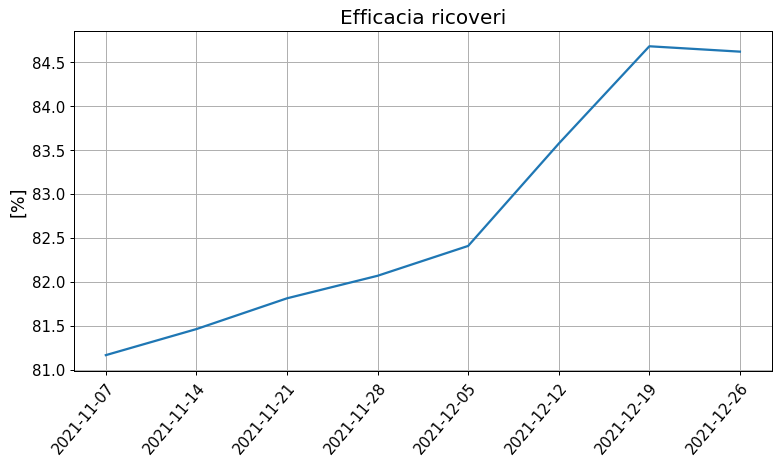

,data,no_vax_100k,vax_100k
104,2021-10-24,NaN,NaN
109,2021-10-31,NaN,NaN
114,2021-11-07,6.130414,0.621348
119,2021-11-14,6.944297,0.652258
124,2021-11-21,8.146572,0.803465
129,2021-11-28,10.088325,0.916204
134,2021-12-05,12.164479,1.053122
139,2021-12-12,14.467387,1.252961
144,2021-12-19,17.094136,1.372975
149,2021-12-26,19.893297,1.500002


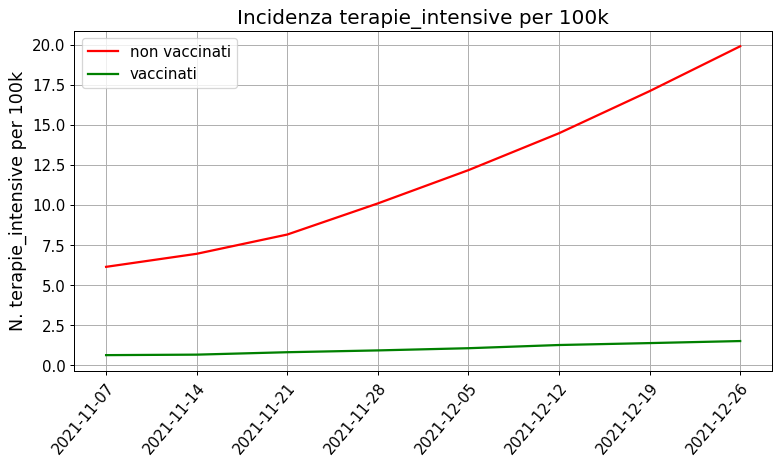

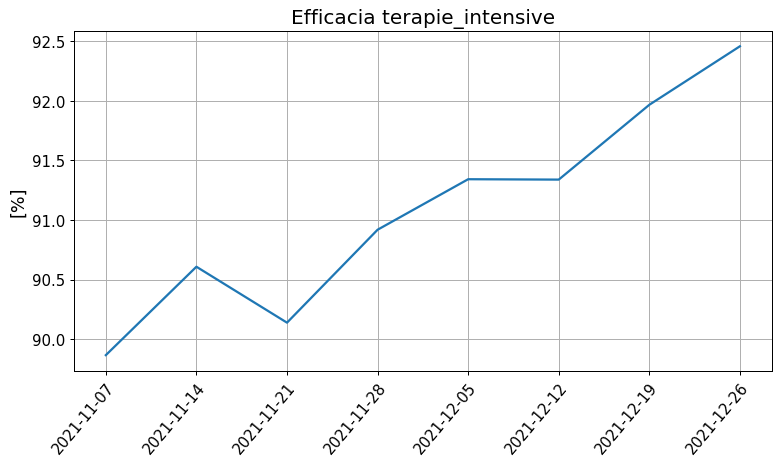

,data,no_vax_100k,vax_100k
154,2021-10-17,NaN,NaN
159,2021-10-24,NaN,NaN
164,2021-10-31,NaN,NaN
169,2021-11-07,6.202678,1.557746
174,2021-11-14,7.885465,1.811587
179,2021-11-21,9.517516,2.225145
184,2021-11-28,11.330796,2.486839
189,2021-12-05,13.631897,2.861838
194,2021-12-12,16.338651,3.368268
199,2021-12-19,20.521496,3.614435


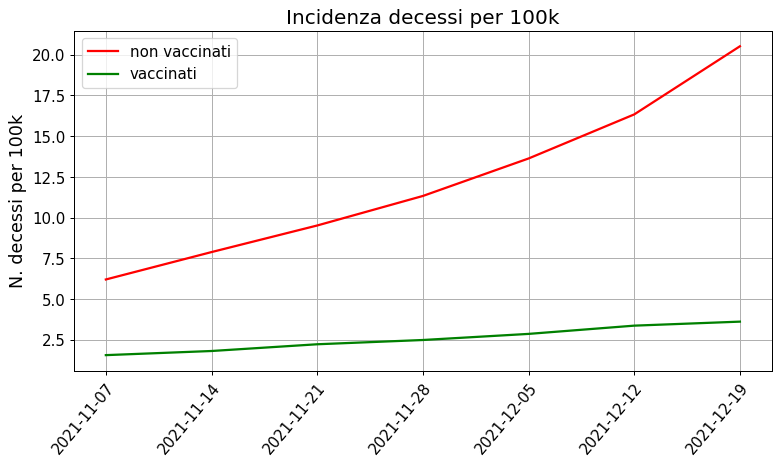

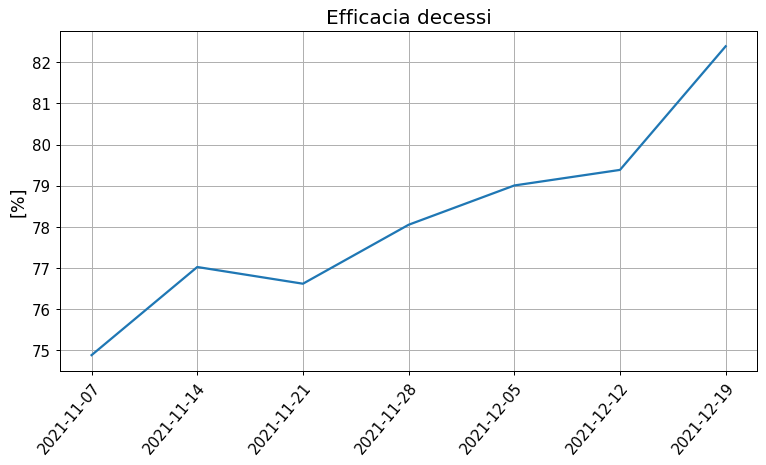

In [43]:
for s in ["contagi","ricoveri","terapie_intensive","decessi"]:
    
    df_plt = df_iss[(df_iss.split==s) & (df_iss.fascia_eta=="totale")]
    display(df_plt[["data","no_vax_100k","vax_100k"]])
    df_plt = df_plt.dropna()
    vplot = [f"{v}_100k" for v in vnames]
    createXYPlot(df_plt,
                 x="data",
                 y=vplot,
                 colors=["r","g"],
                 labels=["non vaccinati", "vaccinati"],
                 plots_folder=plots_folder,
                 title=f"Incidenza {s} per 100k",
                 figsize_x=10,
                 figsize_y=5,
                 dpis=90,
                 ytitle=f"N. {s} per 100k",
                 savename=f"{s}_per_100k",
                 linewidth=1.8,
                 days_interval=1)
    
    createXYPlot(df_plt,
                 x="data",
                 y=["eff"],
                 plots_folder=plots_folder,
                 title=f"Efficacia {s}",
                 figsize_x=10,
                 figsize_y=5,
                 dpis=90,
                 linewidth=1.8,
                 ytitle="[%]",
                 savename=f"efficacia_{s}",
                 days_interval=1)

In [44]:
df_iss[["data","fascia_eta","eff","no_vax_pop","vax_pop","split"]]

,data,fascia_eta,eff,no_vax_pop,vax_pop,split
0,2021-11-07,12-39,79.055474,3649047.0,13786508.0,contagi
1,2021-11-07,40-59,71.807425,3102638.0,15334867.0,contagi
2,2021-11-07,60-79,70.891666,1318627.0,12254152.0,contagi
3,2021-11-07,80+,75.302563,232553.0,4331550.0,contagi
4,2021-11-07,totale,74.788537,8302865.0,45707077.0,contagi
5,2021-11-14,12-39,78.127262,3423613.0,14011942.0,contagi
6,2021-11-14,40-59,71.533242,2932766.0,15504739.0,contagi
7,2021-11-14,60-79,69.827518,1278622.0,12294157.0,contagi
8,2021-11-14,80+,76.140260,227566.0,4336537.0,contagi
9,2021-11-14,totale,74.344345,7862567.0,46147375.0,contagi


In [45]:
def plot_vax_vs_no_vax(age: str, 
                       split: str):
    
    plt.figure(dpi=100, figsize=(10,5))
    df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)].reset_index()
    title = f"{split}"
    if age != "totale":
        title += f" {age}"
    createXYPlot(df_plt,
                 y=["no_vax_frac"],
                 labels=["frazione non vaccinati"],
                 colors=["r"],
                 x="data",
                 plots_folder="./plots",
                 days_interval=1,
                 linewidth=1.8,
                 title=title.replace("_"," ")
                )

<Figure size 1000x500 with 0 Axes>

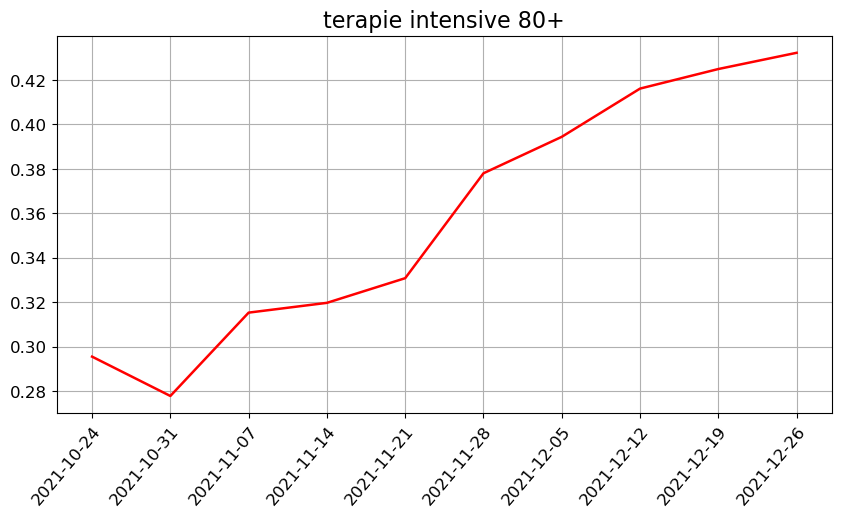

In [46]:
plot_vax_vs_no_vax("80+", "terapie_intensive")

In [47]:
df_iss["no_vax_frac_err"] = 1.645*np.sqrt((df_iss["no_vax_frac"]*df_iss["vax_frac"])/(df_iss["no_vax"] + df_iss["vax"]))
df_iss["no_vax_frac_err_lo"] = df_iss["no_vax_frac"] - df_iss["no_vax_frac_err"]
df_iss["no_vax_frac_err_hi"] = df_iss["no_vax_frac"] + df_iss["no_vax_frac_err"]

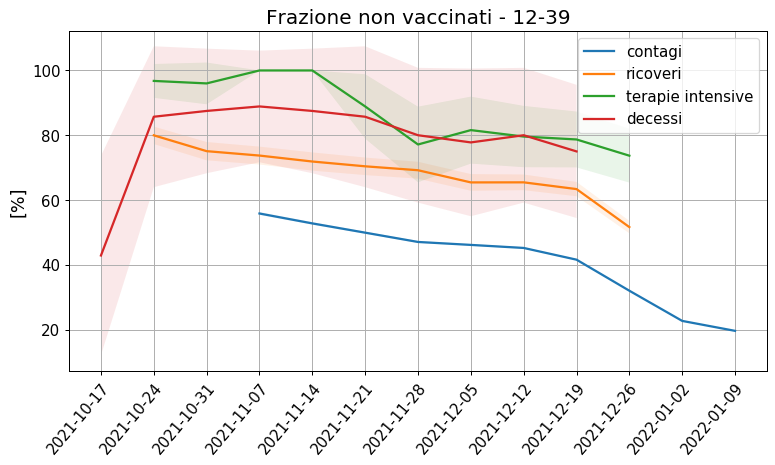

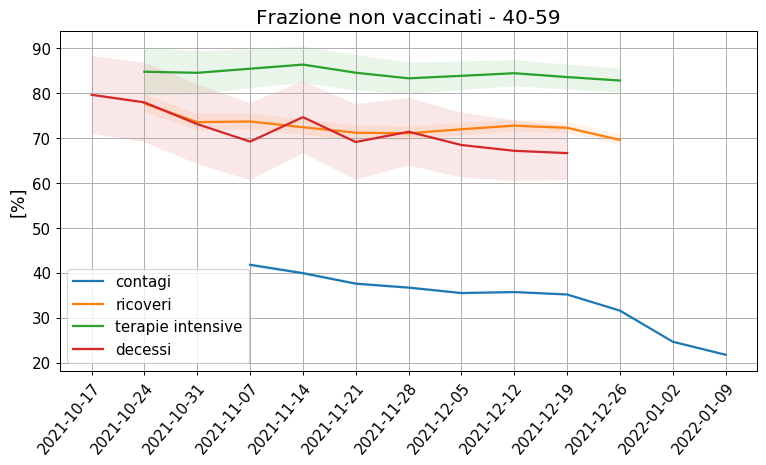

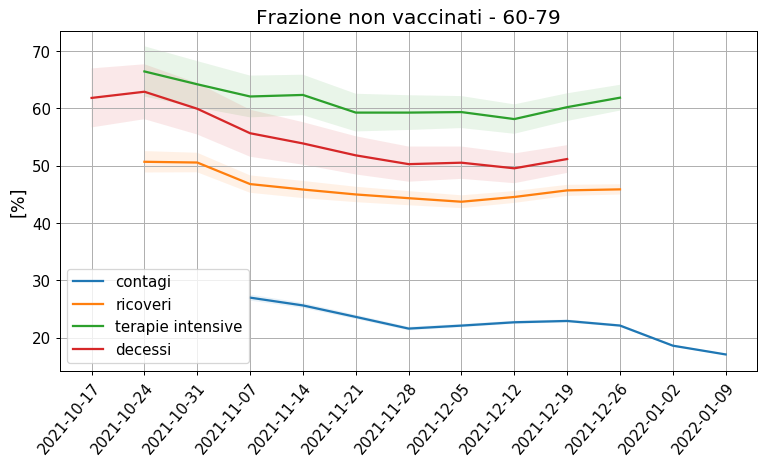

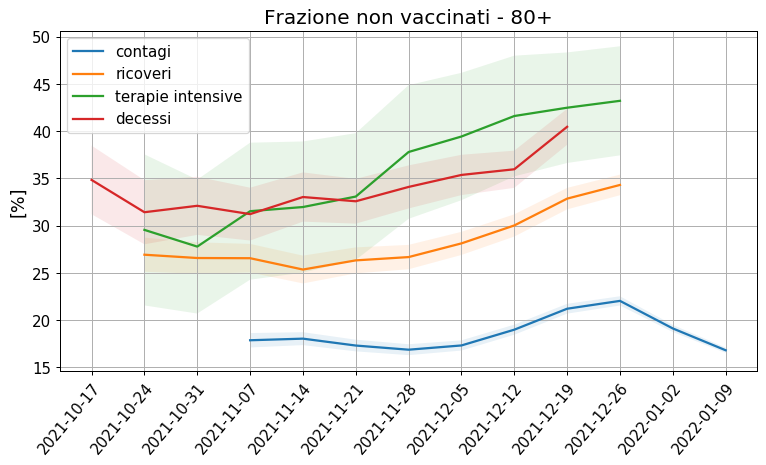

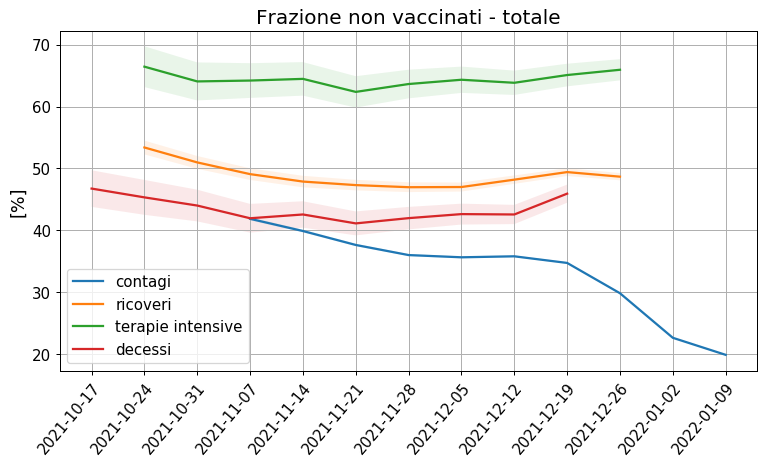

In [48]:
for age in sorted(age_values):
    plt.figure(dpi=90, figsize=(10,5))
    dates_str = []
    dates = []
    for split in ["contagi", "ricoveri", "terapie_intensive", "decessi"]:
        df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)]
        dates_str += [x.strftime("%Y-%m-%d") for x in df_plt.data.unique()]
        dates += [x for x in df_plt.data.unique()]
        plt.plot(df_plt.data,
                 100*df_plt.no_vax_frac,
                 label=split.replace("_"," "),
                 linewidth=1.8
                )
        plt.fill_between(df_plt.data, 
                     100*df_plt.no_vax_frac_err_lo, 
                     100*df_plt.no_vax_frac_err_hi,
                     alpha=0.1
                    )
    title = f"Frazione non vaccinati - {age}"
    plt.title(title, fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("[%]",fontsize=14)
    
    dates_str = sorted(list(set(dates_str)), reverse=False)
    dates = sorted(list(set(dates)), reverse=False)
    plt.xticks(dates,
               dates_str,
               fontsize=12,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right")
    plt.savefig(f"{plots_folder}/frazione_no_vax_{age}",bbox_inches="tight")

In [49]:
def plot_var_ages(split, varname="vax"):
    plt.figure(dpi=90, figsize=(10,5))
    for age in sorted(age_values):
        df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split=="terapie_intensive")]
        plt.plot(df_plt.data,
            df_plt[varname],
            label=age,
            linewidth=1.8)
    title = f"Totale {varname} {split}".replace("_", " ")
    plt.title(title, fontsize=16)
    plt.grid()
    plt.legend(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks(df_plt.data,
               fontsize=12,
               rotation=50, 
               rotation_mode="anchor", 
               verticalalignment = "top",
               horizontalalignment = "right"
              )

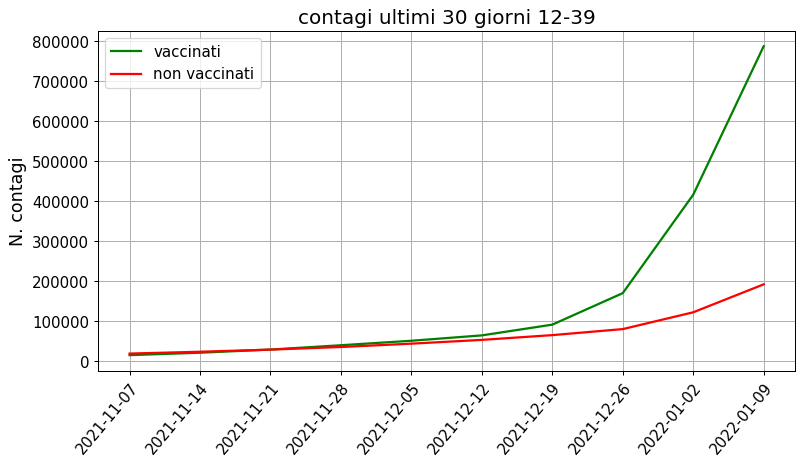

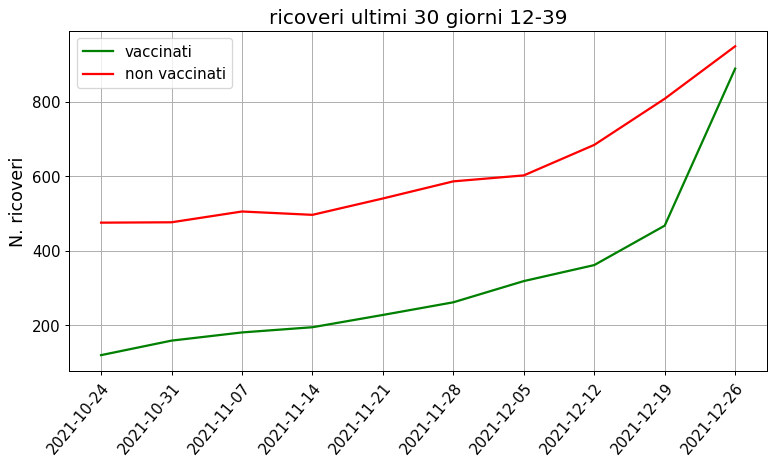

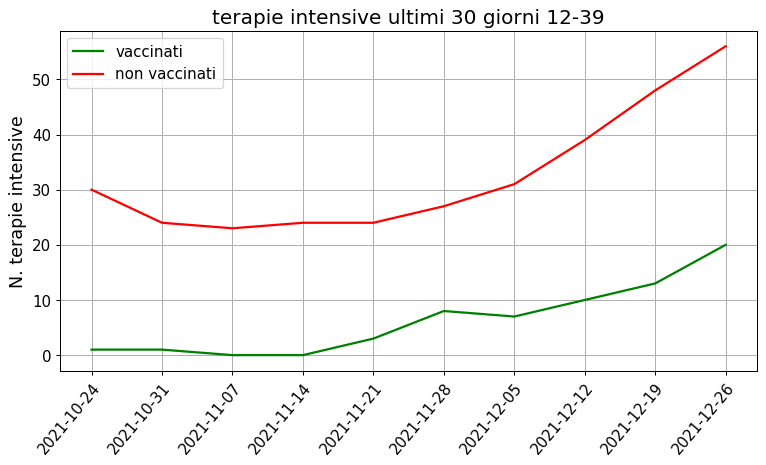

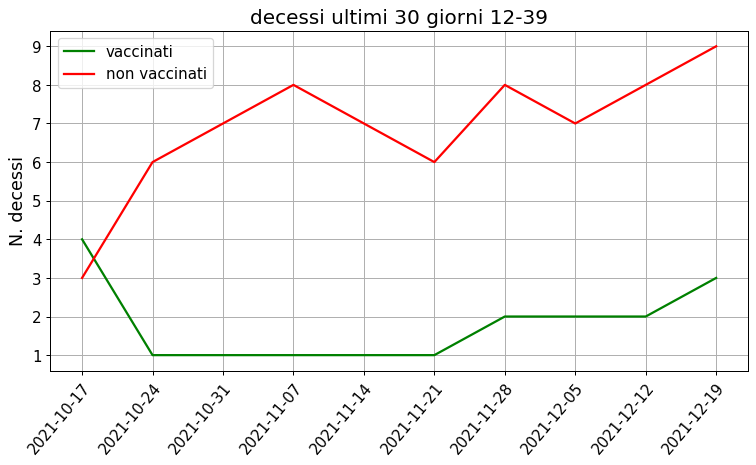

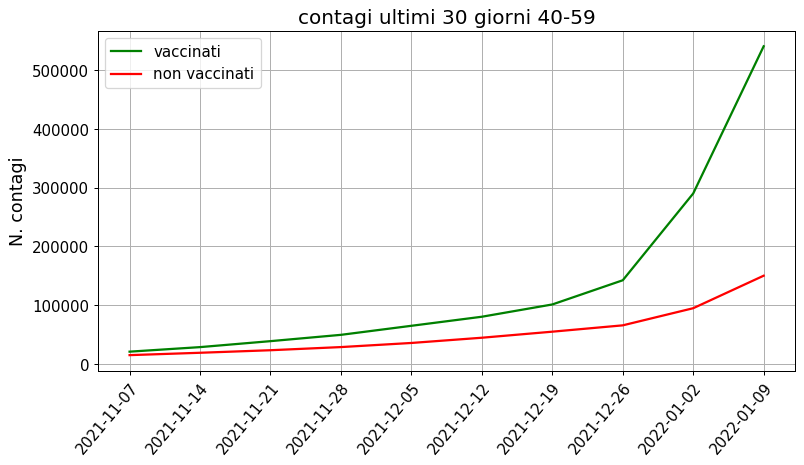

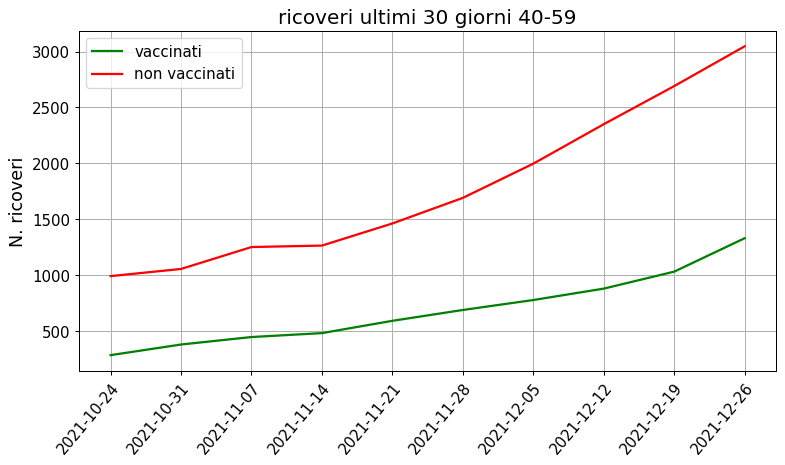

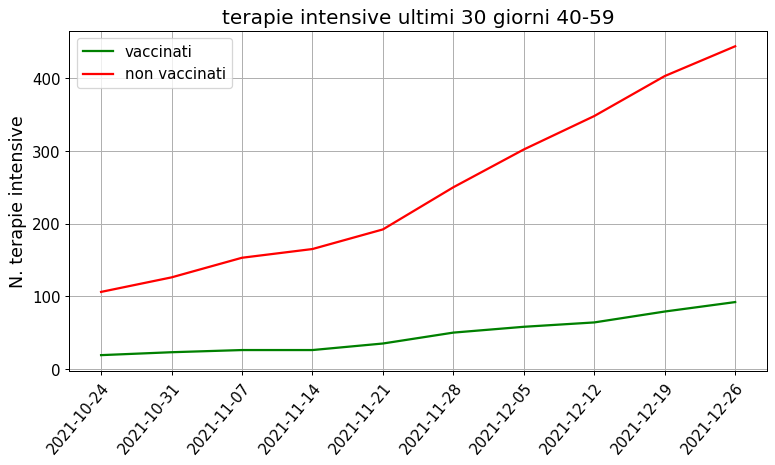

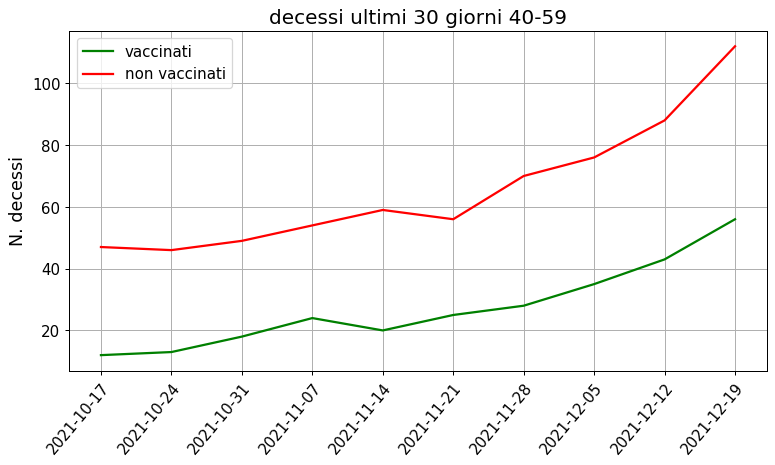

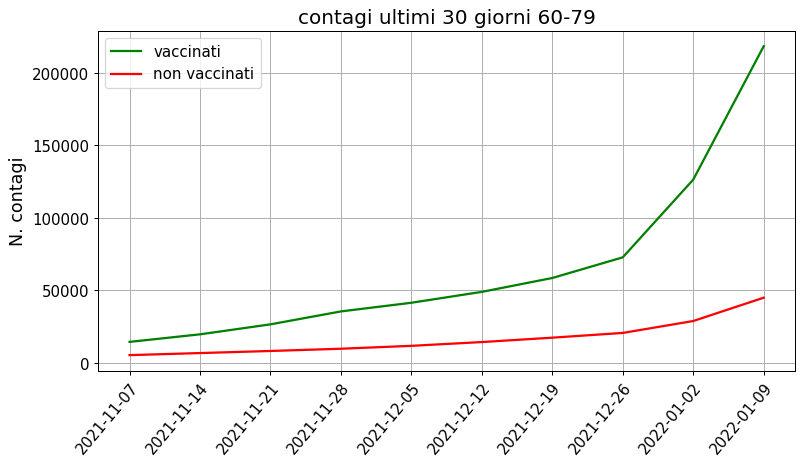

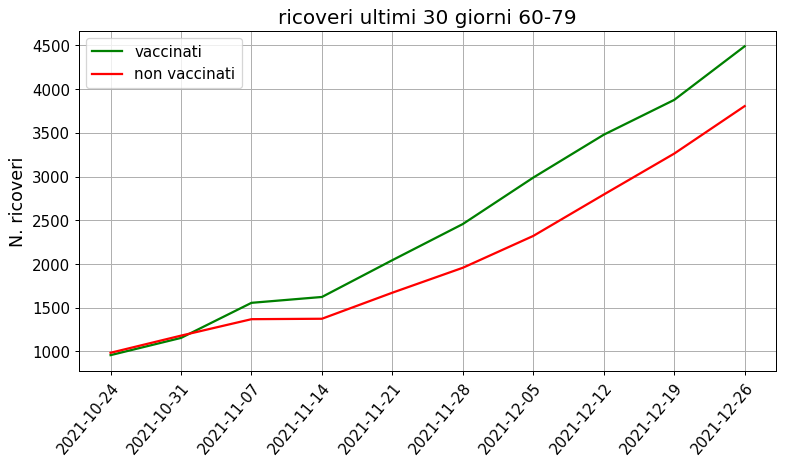

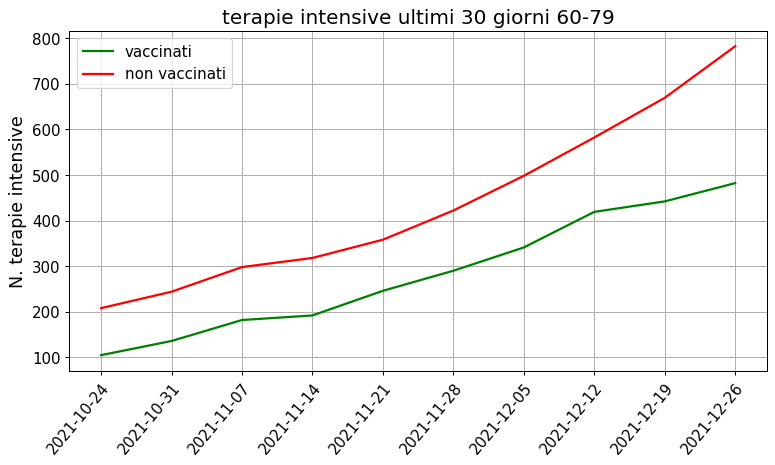

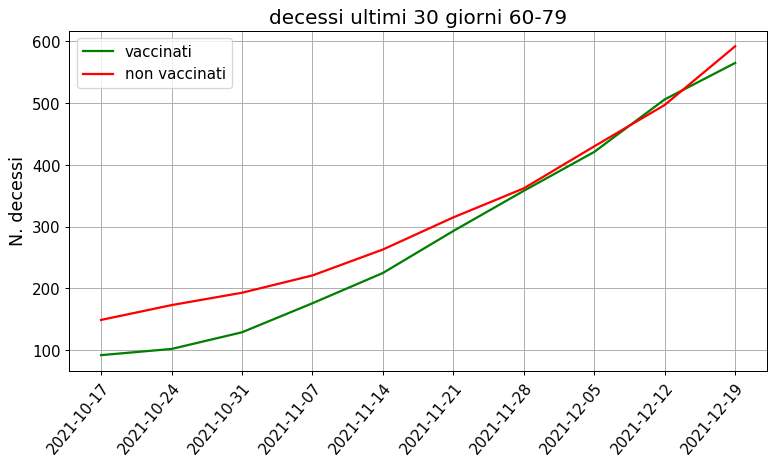

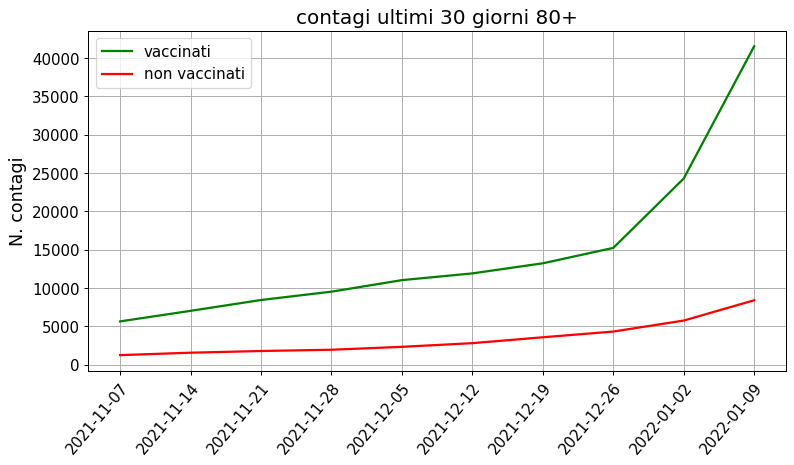

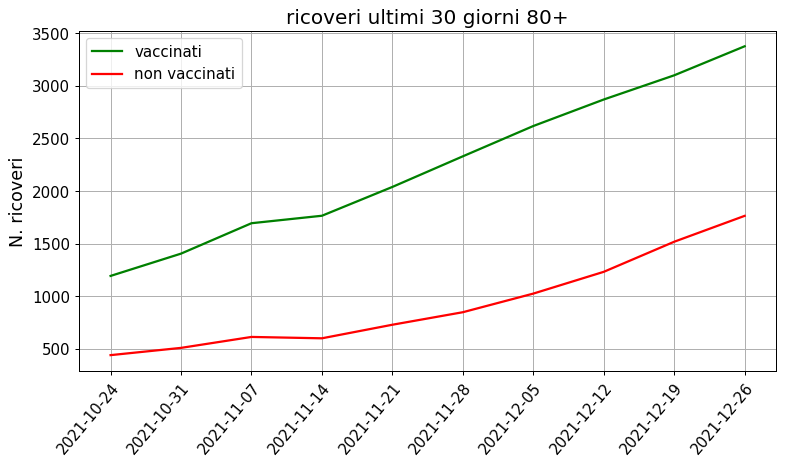

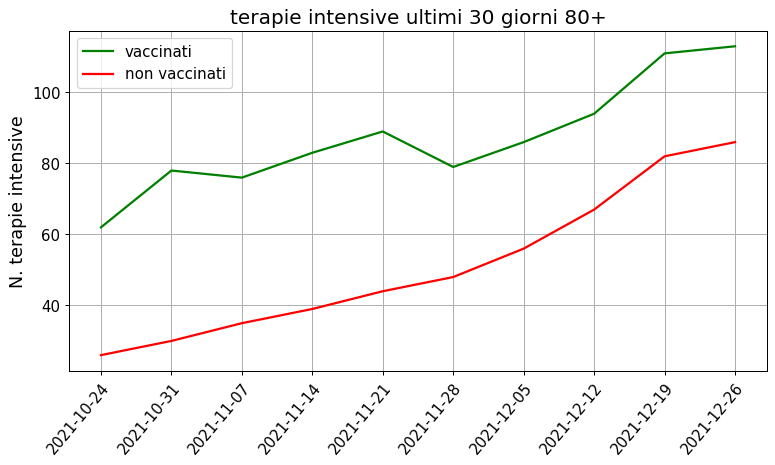

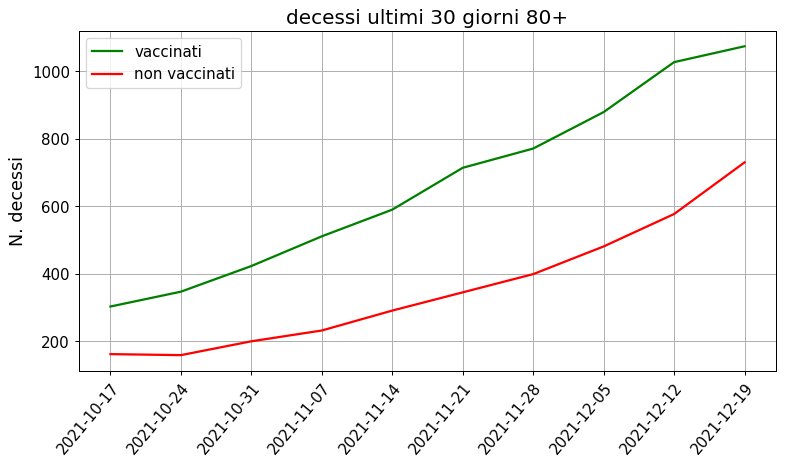

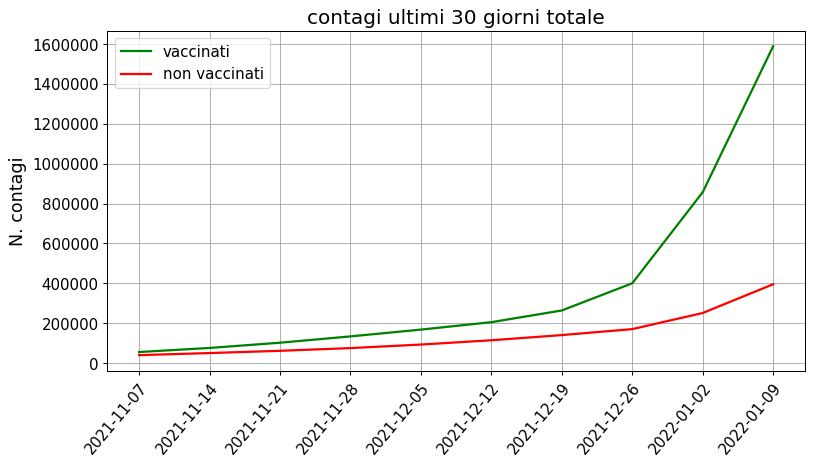

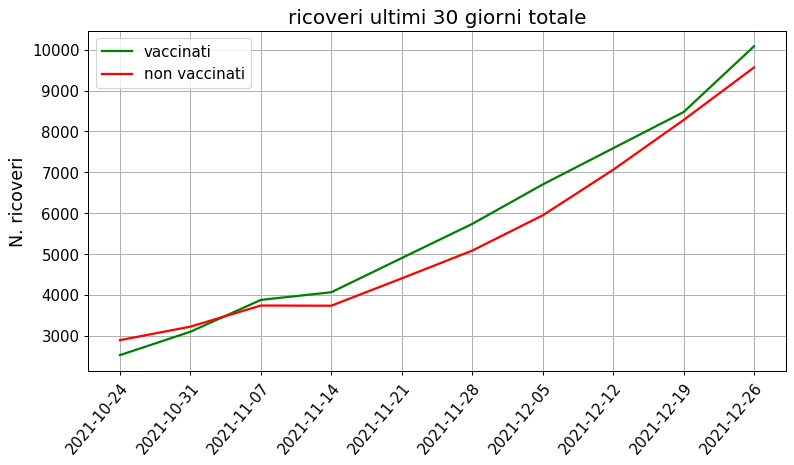

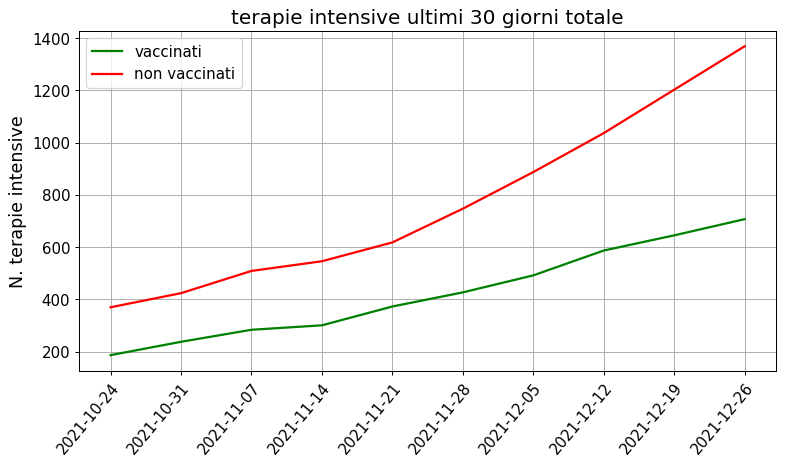

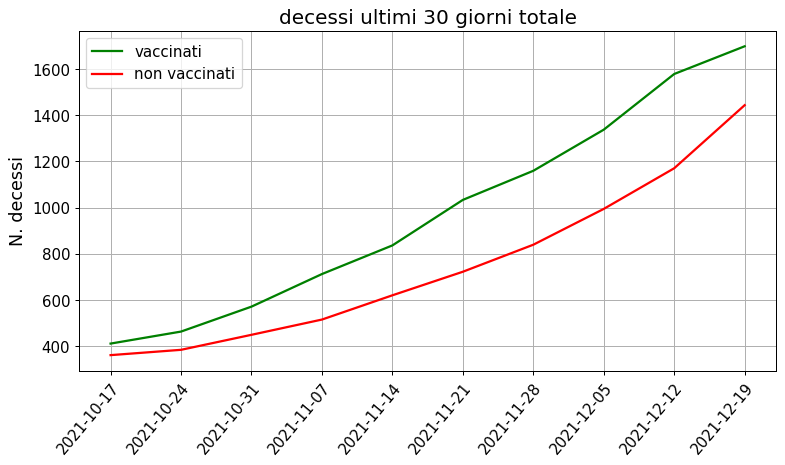

In [50]:
for age in age_values:
    for split in splits:
        df_plt = df_plt = df_iss[(df_iss.fascia_eta==age) & (df_iss.split==split)]
        savename = f"{split}_{age}"
        yvars = ["vax", "no_vax"]
        savename += "_" + "_".join(yvars)
        createXYPlot(df_plt,
                     y=yvars,
                     x="data",
                     labels=["vaccinati", "non vaccinati"],
                     colors=["g","r"],
                     plots_folder=plots_folder,
                     linewidth=1.8,
                     days_interval=1,
                     title=f"{split} ultimi 30 giorni {age}".replace("_"," "),
                     savename=savename,
                     ytitle=f"N. {split}".replace("_"," "),
                     figsize_x=10,
                     figsize_y=5,
                     dpis=90
                    )

In [51]:
def get_lethality(df: pd.DataFrame, 
                  savename: str,
                  title: str,
                  yscale: str ="linear",
                  num_den: tuple = ("decessi","contagi"),
                 ):

    value_cols = ["vax",
                  "no_vax",
                  "1_dose",
                  "2_dosi_lt_cut",
                  "2_dosi_gt_cut",
                  "booster",
                 ]
    df_pivot = df.pivot(index='data',columns=["split"],values=value_cols)
    cols = []
    for i in range(0,len(df_pivot.columns)):
        cols.append(df_pivot.columns.get_level_values(1)[i] + '_' + df_pivot.columns.get_level_values(0)[i])
    df_pivot.columns = cols

    for v in value_cols:
        df_pivot[f"letalita_{v}"] = df_pivot[f"{num_den[0]}_{v}"]/df_pivot[f"{num_den[1]}_{v}"]
        df_pivot[f"sd_letalita_{v}"] = np.sqrt(df_pivot[f"letalita_{v}"] * (1 - df_pivot[f"letalita_{v}"]) / df_pivot[f"contagi_{v}"])
        df_pivot[f"lo_err_letalita_{v}"] = df_pivot[f"letalita_{v}"] - 1.645 * df_pivot[f"sd_letalita_{v}"]
        df_pivot[f"hi_err_letalita_{v}"] = df_pivot[f"letalita_{v}"] + 1.645 * df_pivot[f"sd_letalita_{v}"]
        df_pivot[f"lo_err_letalita_{v}"] = df_pivot[f"lo_err_letalita_{v}"].apply(lambda x: 0 if x < 0 else x)
    
    dates = df_pivot.dropna().index
    plt.figure(figsize=(10,5),dpi=90)
    for y in ["no_vax", "1_dose", "2_dosi_lt_cut", "2_dosi_gt_cut", "booster"]:
        plt.plot(df_pivot.index, 
                 100*df_pivot[f"letalita_{y}"],
                 label=y,
                 linewidth=1.8
                )
        plt.fill_between(df_pivot.index, 
                     100*df_pivot[f"lo_err_letalita_{y}"], 
                     100*df_pivot[f"hi_err_letalita_{y}"],
                     alpha=0.1
                    )
    plt.grid()
    plt.legend(fontsize=12)
    plt.title(f"{title} -- {age} -- dati ISS",fontsize=19)
    plt.ylabel(f"{num_den[0]} / {num_den[1]} [%]",fontsize=14)
    _ = plt.yticks(fontsize=13)
    _ = plt.xticks(dates,
                   fontsize=13,
                   rotation=50, 
                   rotation_mode="anchor", 
                   verticalalignment = "top",
                   horizontalalignment = "right"
                  )
    plt.yscale(yscale)
    plt.savefig(f"./plots/{savename}.png", bbox_inches="tight")

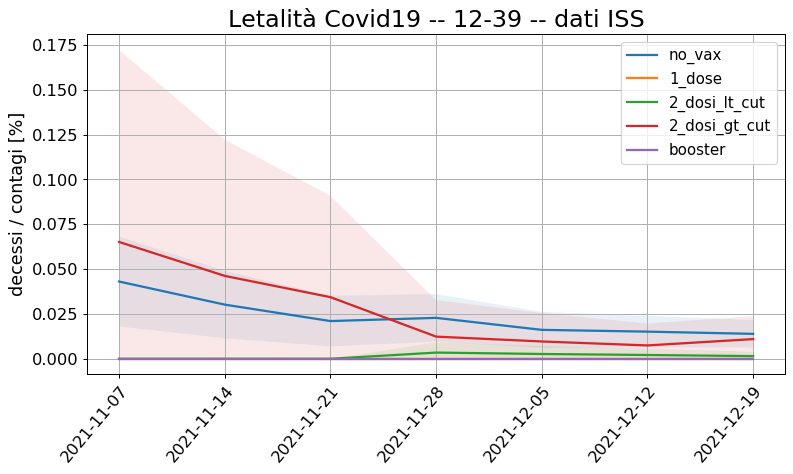

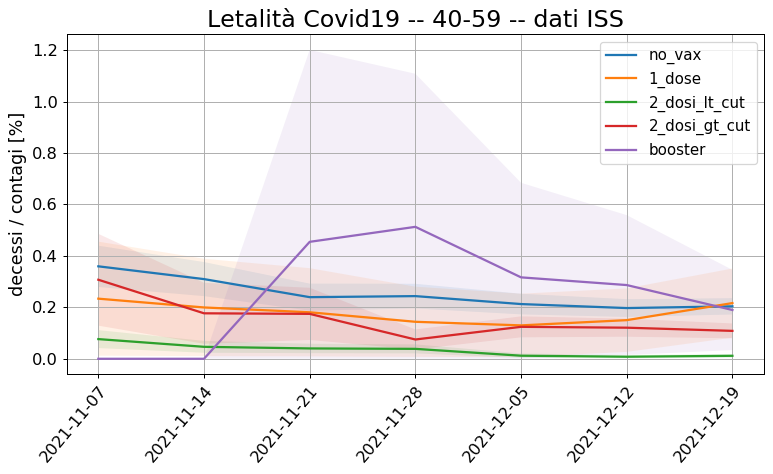

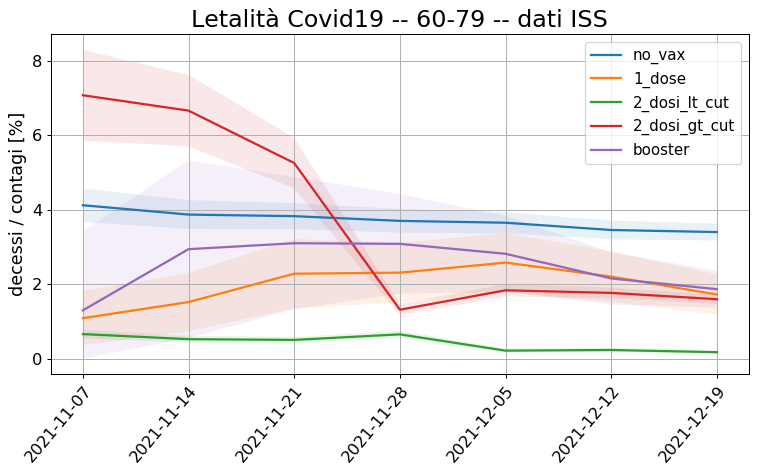

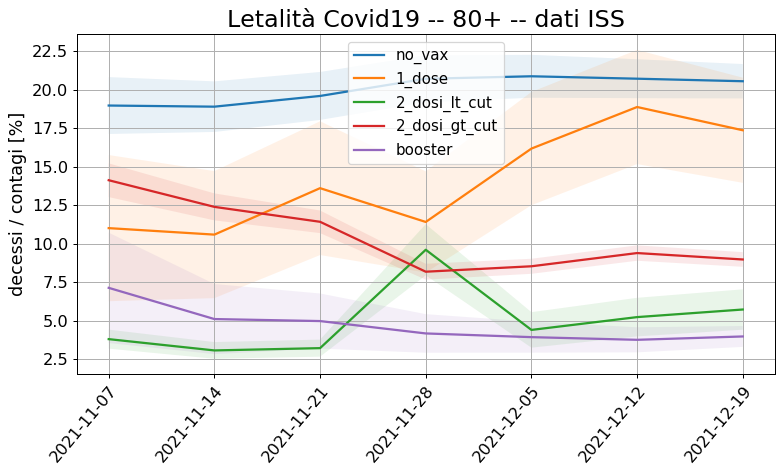

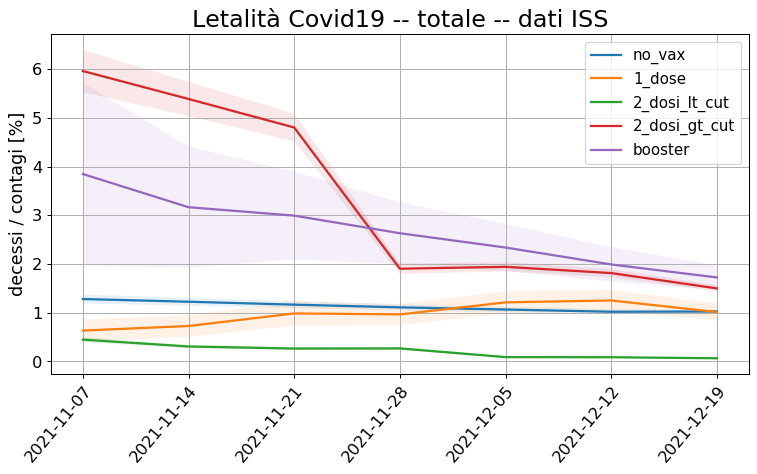

In [52]:
for age in age_values:
    df_let = df_iss[df_iss.fascia_eta==age]
    get_lethality(df_let,
                  savename=f"letalita_iss_{age}",
                  title="Letalità Covid19",
                  yscale="linear"
                 )

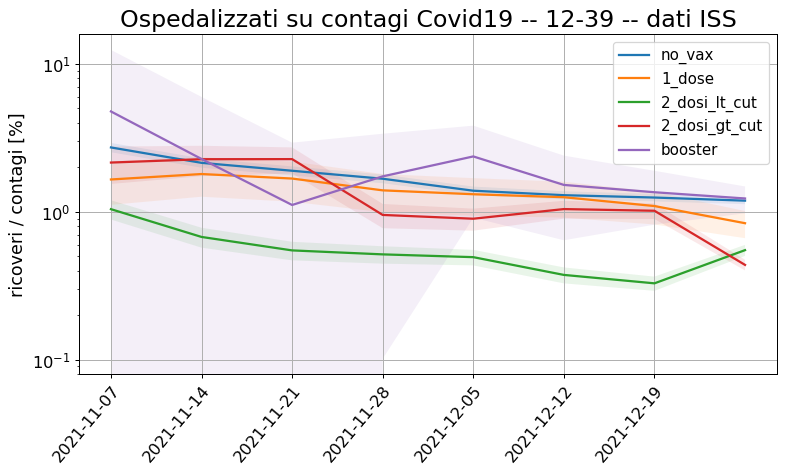

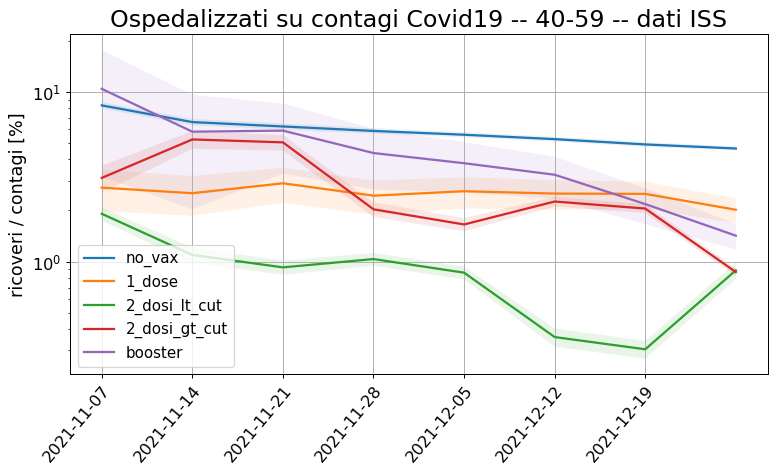

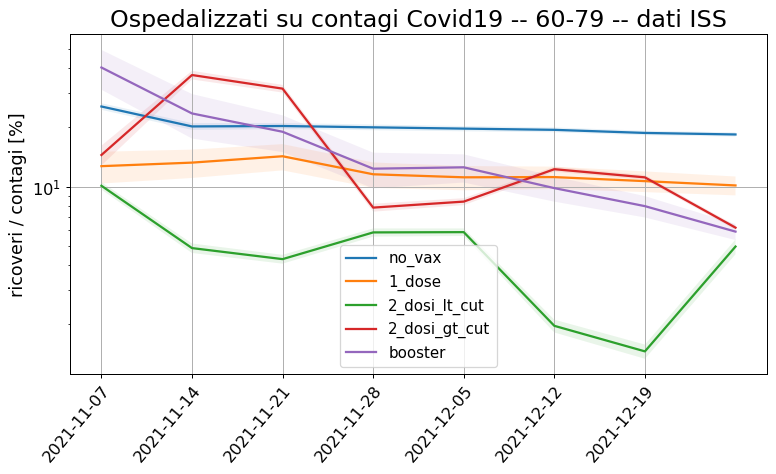

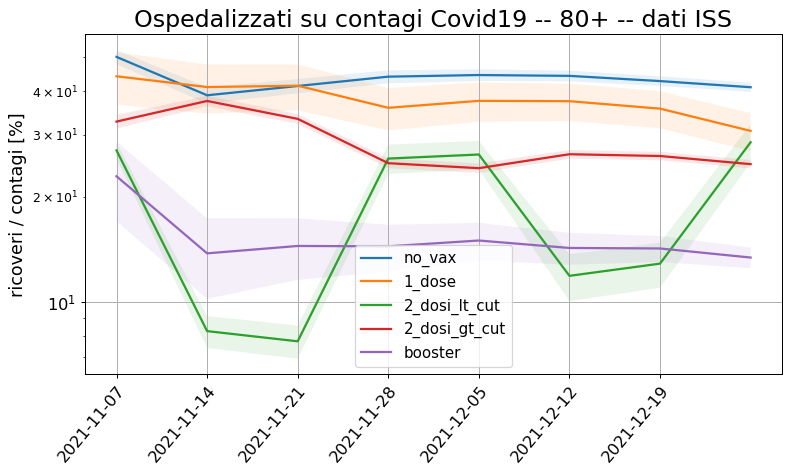

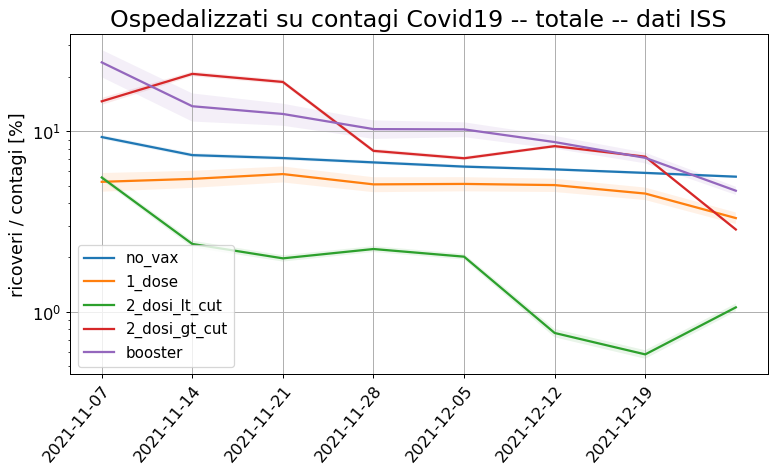

In [55]:
for age in age_values:
    df_let = df_iss[df_iss.fascia_eta==age]
    get_lethality(df_let,
                  savename=f"ospedalizzati_contagi_iss_{age}",
                  title="Ospedalizzati su contagi Covid19",
                  yscale="log",
                  num_den=("ricoveri","contagi")
                 )

In [27]:
from dateutil.relativedelta import relativedelta
path = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df_daily = getVariables(pd.read_csv(path))


df_daily["data"] = pd.to_datetime(df_daily["data"])
df_daily["data"] = df_daily["data"].apply(lambda x: x.date())
df_daily["data_prev"] = pd.to_datetime("2021-12-10")

In [494]:
df_test = df_daily[(df_daily.data > datetime.strptime("2021-12-10","%Y-%m-%d").date()) & 
         (df_daily.data < datetime.strptime("2022-01-09","%Y-%m-%d").date())][["data","dow","nuovi_positivi"]]

In [495]:
np.sum(df_test["nuovi_positivi"])

2096038

In [500]:
np.sum(df_contagi[df_contagi.fascia_eta=="totale"][["vax","no_vax"]],axis=1)

4       95950
9      126703
14     164396
19     209587
24     261352
29     320068
34     404745
39     570898
44    1108367
49    1983622
dtype: int64

In [489]:
for v in ["ingressi_terapia_intensiva", "nuovi_positivi"]:
    df_daily[f"{v}_last_month"] = df_daily.apply(lambda x: df_daily.loc[(df_daily.data >= x.data_prev) & 
                                                                 (df_daily.data < x.data), v].sum(), axis=1)


In [490]:
df_ti_comp      = df_ti[df_ti.fascia_eta=="totale"][["data","vax","no_vax"]]
df_contagi_comp = df_contagi[df_contagi.fascia_eta=="totale"][["data","vax","no_vax"]]

df_ti_comp["data"] = pd.to_datetime(df_ti_comp["data"]).apply(lambda x: x.date())
df_contagi_comp["data"] = pd.to_datetime(df_contagi_comp["data"]).apply(lambda x: x.date())

df_daily_comp = df_daily[["data","ingressi_terapia_intensiva_last_month","nuovi_positivi_last_month"]]

In [478]:
df_comp_contagi = df_daily_comp.merge(df_contagi_comp, on="data", how="inner")
df_comp_contagi["tot"] = df_comp_contagi["vax"] + df_comp_contagi["no_vax"]
df_comp_contagi["diff"] = df_comp_contagi["tot"] - df_comp_contagi["nuovi_positivi_last_month"] 

,data,nuovi_positivi
655,2021-12-10,20497
656,2021-12-11,21042
657,2021-12-12,19215
658,2021-12-13,12712
659,2021-12-14,20677
660,2021-12-15,23195
661,2021-12-16,26109
662,2021-12-17,28632
663,2021-12-18,28064
664,2021-12-19,24259


In [480]:
df_comp_contagi[["data","nuovi_positivi_last_month","tot","diff"]]

,data,nuovi_positivi_last_month,tot,diff
0,2021-11-07,0,95950,95950
1,2021-11-14,0,126703,126703
2,2021-11-21,0,164396,164396
3,2021-11-28,0,209587,209587
4,2021-12-05,0,261352,261352
5,2021-12-12,41539,320068,278529
6,2021-12-19,200143,404745,204602
7,2021-12-26,457662,570898,113236
8,2022-01-02,1102187,1108367,6180
9,2022-01-09,2116535,1983622,-132913


In [ ]:
df_comp = df_daily_comp.merge(df_ti_comp, on="data", how="inner")
df_comp["tot"] = df_comp["vax"] + df_comp["no_vax"]
df_comp["diff"] = df_comp["tot"] - df_comp["ingressi_terapia_intensiva_last_month"] 

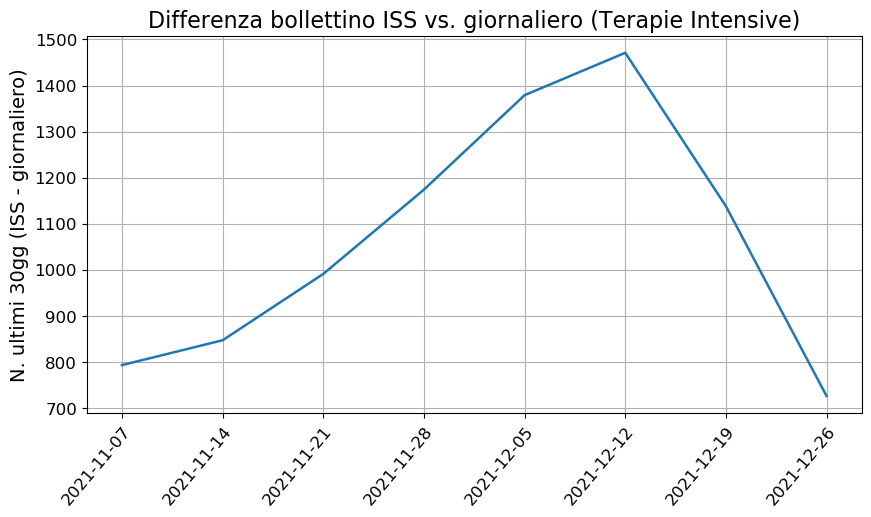

In [460]:
createXYPlot(df_comp,
             x="data",
             y=["diff"],
             title="Differenza bollettino ISS vs. giornaliero (Terapie Intensive)",
             plots_folder=None,
             days_interval=1,
             linewidth=1.8,
             start_date="2021-11-01",
             ytitle="N. ultimi 30gg (ISS - giornaliero)"
            )

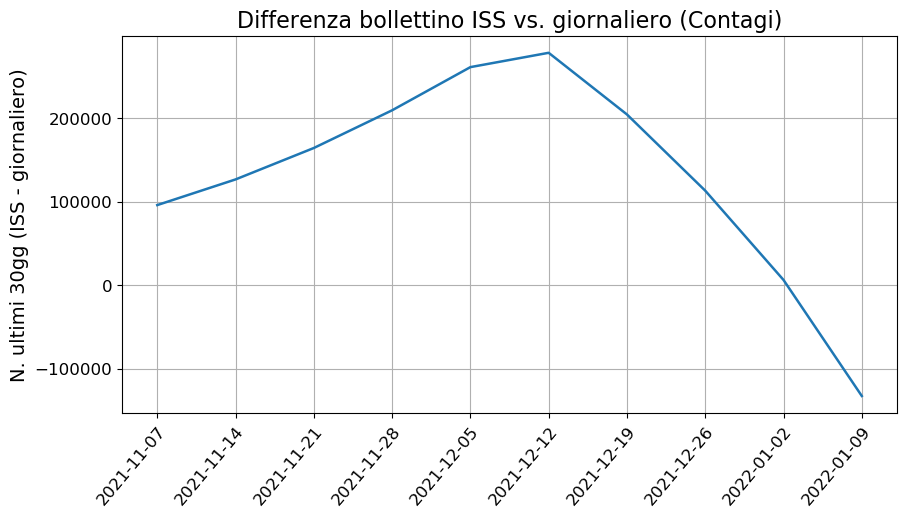

In [462]:
createXYPlot(df_comp_contagi,
             x="data",
             y=["diff"],
             title="Differenza bollettino ISS vs. giornaliero (Contagi)",
             plots_folder=None,
             days_interval=1,
             linewidth=1.8,
             start_date="2021-11-01",
             ytitle="N. ultimi 30gg (ISS - giornaliero)"
            )

In [453]:
df_comp_contagi

,data,ingressi_terapia_intensiva_last_month,nuovi_positivi_last_month,vax,no_vax,tot,diff
0,2021-11-07,0.0,0,55768,40182,95950,95950
1,2021-11-14,0.0,0,76139,50564,126703,126703
2,2021-11-21,0.0,0,102488,61908,164396,164396
3,2021-11-28,0.0,0,134075,75512,209587,209587
4,2021-12-05,0.0,0,168132,93220,261352,261352
5,2021-12-12,206.0,60754,205394,114674,320068,259314
6,2021-12-19,787.0,224402,264068,140677,404745,180343
7,2021-12-26,1434.0,482545,400347,170551,570898,88353
8,2022-01-02,2271.0,1163233,856955,251412,1108367,-54866
9,2022-01-09,3252.0,2272194,1588198,395424,1983622,-288572
